### Initial Setup, Get Dataset Directories

In [1]:
import os
import numpy as np
from PIL import Image

# Base directory where you extracted the AI4Mars data
base_dir = '/home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data' 
# Directories for the training images and their corresponding masks
mer_dir = os.path.join(base_dir, 'mer/')
msl_dir = os.path.join(base_dir, 'msl/')

# Directories for the testing images and their corresponding masks
mer_train_img_dir = os.path.join(mer_dir, 'images/train')
mer_test_img_dir = os.path.join(mer_dir, 'images/test')
mer_train_mask_dir = os.path.join(mer_dir, 'labels/train/merged-unmasked')
mer_test_mask_dir = os.path.join(mer_dir, 'labels/test/masked-gold-min1-100agree')

# msl_train_img_dir = os.path.join(msl_dir, 'images/train')
# msl_test_img_dir = os.path.join(msl_dir, 'images/test')
# msl_train_mask_dir = os.path.join(msl_dir, 'labels/train')
# msl_test_mask_dir = os.path.join(msl_dir, 'labels/test')

print(f"MER Training Images Directory: {mer_train_img_dir}")
print(f"MER Testing Images Directory {mer_test_img_dir}")
print(f"MER Training Mask Directory {mer_train_mask_dir}")
print(f"MER Testing Mask Directory {mer_test_mask_dir }")

# print(f"MSL Training Images Directory: {msl_train_img_dir}")
# print(f"MSL Testing Images Directory {msl_test_img_dir}")
# print(f"MSL Training Mask Directory {msl_train_mask_dir}")
# print(f"MSL Testing Mask Directory {msl_test_mask_dir }")

MER Training Images Directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
MER Testing Images Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
MER Training Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
MER Testing Mask Directory /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree


### Functions

In [2]:
import os
import re
from typing import List, Tuple

# Allowed extensions for the AI4Mars dataset images and masks
ALLOWED_EXTENSIONS = ('.jpg', '.png', '.jpeg')

def get_base_name(filename: str) -> str:
    # 1. Remove file extension
    base = os.path.splitext(filename)[0]
    
    # Suffix Removal Pattern (case-insensitive, applied only at the end)
    # Pattern explanation:
    #   (_\d{5}_T\d_merged) : Targets the Test Mask structure (e.g., _16165_T0_merged)
    #    | _merged\d* : Targets the Train Mask structure (e.g., _merged0, _merged1)
    #    | _mer              : Handles general _mer cases
    #    The entire match must be at the end of the string ($)
    suffix_pattern = r'(_\d{5}_T\d_merged|_merged\d*|_mer)$'
    base = re.sub(suffix_pattern, '', base, flags=re.IGNORECASE)
    
    return base

def get_matched_pairs(img_dir: str, mask_dir: str) -> List[Tuple[str, str]]:

    print(f"\n[Matching] Checking image directory: {img_dir}")
    print(f"[Matching] Checking mask directory: {mask_dir}")
    
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        print("Error: One or both directories do not exist.")
        return []

    image_files = sorted([f for f in os.listdir(img_dir) 
                          if f.lower().endswith(ALLOWED_EXTENSIONS)])
    mask_candidates = [f for f in os.listdir(mask_dir) 
                       if f.lower().endswith(ALLOWED_EXTENSIONS)]
    
    print(f"[Matching] Found {len(image_files)} potential images.")
    print(f"[Matching] Found {len(mask_candidates)} mask candidates.")

    # Build the Mask Lookup Map (Base Name -> Mask Full Path)
    mask_map = {}
    for mask_file in mask_candidates:
        base_name = get_base_name(mask_file)
        mask_map[base_name] = os.path.join(mask_dir, mask_file)
            
    # Find Matches
    matched_pairs = []
    unmatched_images = []
    
    for img_filename in image_files:
        img_base_name = get_base_name(img_filename)
        
        if img_base_name in mask_map:
            img_path = os.path.join(img_dir, img_filename)
            mask_path = mask_map[img_base_name]
            matched_pairs.append((img_path, mask_path))
        else:
            unmatched_images.append(img_filename)

    print(f"[Matching] Successfully identified {len(matched_pairs)} image/mask pairs.")
    if unmatched_images:
        print(f"[Matching] Warning: {len(unmatched_images)} images had NO matching mask.")
        # Provide a specific example of the failure for debugging future issues
        if unmatched_images:
            ex_img_name = unmatched_images[0]
            ex_img_base = get_base_name(ex_img_name)
            print(f"DEBUG: Example unmatched image '{ex_img_name}' resulted in base name '{ex_img_base}'.")
    
    return matched_pairs

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# --- GLOBAL CONSTANTS ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
TARGET_SIZE = (224, 224)

NUM_RISK_CLASSES = 3
RISK_CLASS = {
    'low': 0,       # Class 0: Mostly safe terrain
    'medium': 1,    # Class 1: Moderate risk features
    'high': 2       # Class 2: High density of dangerous features
}
NUM_TERRAIN_CLASSES = 5 
RAW_TO_INDEX = {0: 0, 1: 1, 2: 2, 3: 3, 255: 4}
MASK_MAPPING = {
    0: 'soil',
    1: 'bedrock',
    2: 'sand',
    3: 'big_rock',
    255: 'null'
}

# Supported file extensions for robust loading
ALLOWED_EXTENSIONS = ('.png', '.jpg', '.jpeg')


# --- 1. DATA PREPARATION FUNCTIONS (Updated for Case-Insensitive File Check) ---

def calculate_risk_class(mask_labels):
    """
    Calculates the risk class (0, 1, or 2) based on the terrain pixel counts.
    Bedrock's presence prevents Low Risk classification due to cited wheel wear.
    """
    sand_count = mask_labels.get('sand', 0)
    rock_count = mask_labels.get('big_rock', 0)
    soil_count = mask_labels.get('soil', 0)
    
    # Total includes all measured terrain types (Sand, Rock, Soil, Bedrock)
    total = sand_count + rock_count + soil_count + mask_labels.get('bedrock', 0)
    
    if total == 0:
        return 1 # Default to Medium Risk

    sand_pct = sand_count / total
    rock_pct = rock_count / total
    soil_pct = soil_count / total
    
    #  High Risk Check (Hazard Domination)
    if sand_pct > 0.30 or rock_pct > 0.30:
        return 2 # High Risk
    
    # Low Risk Check (Soil Domination, Hazard Absence)
    # Note: Bedrock's absence here means a large bedrock area defaults to Medium (1)
    elif soil_pct > 0.60 and sand_pct < 0.15 and rock_pct < 0.20:
        return 0 # Low Risk (Cohesive soil is the ideal traverse surface)
        
    # Medium Risk (Bedrock-heavy, mixed, or marginally safe terrain)
    else:
        return 1 # Medium Risk
    
def _parse_mask_for_risk(mask_path_tensor, n_classes=NUM_RISK_CLASSES):
    """
    GLOBAL FUNCTION: Loads mask file path, decodes it, calculates pixel counts, 
    and returns the one-hot encoded risk label.
    """
    
    mask_bytes = tf.io.read_file(mask_path_tensor)
    mask = tf.image.decode_png(mask_bytes, channels=1)
    mask = tf.image.resize(mask, TARGET_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(tf.squeeze(mask), dtype=tf.uint8) 

    def py_calculate_risk(mask_np):
        pixel_counts = {}
        for raw_value, terrain_name in MASK_MAPPING.items():
            if terrain_name == 'null': continue 
            count = np.sum(mask_np == raw_value)
            pixel_counts[terrain_name] = count
        
        risk_class = calculate_risk_class(pixel_counts)
        return to_categorical(risk_class, num_classes=n_classes)
        
    risk_label = tf.numpy_function(
        func=py_calculate_risk,
        inp=[mask],
        Tout=tf.float32,
        name='calculate_risk_label'
    )
    # tf.numpy_function needs explicit shape setting
    risk_label.set_shape([n_classes]) 
    return risk_label

def create_tf_dataset(img_dir, mask_dir, batch_size=32, target_size=(224, 224), 
                      n_classes=3, test_size=0.1, random_state=42):
    """
    Creates the GPU-accelerated tf.data.Dataset pipelines for training, validation,
    and testing by loading only file paths into memory, solving the crash issue.
    
    Returns: train_ds, val_ds, test_ds, total_train_samples
    """
    
    # Get ALL file paths for training (disk only)
    full_train_pairs = get_matched_pairs(img_dir, mask_dir)
    
    if not full_train_pairs:
        raise ValueError("No matched pairs found for training data.")

    # Split the file paths into train/validation lists
    train_paths, val_paths = train_test_split(
        full_train_pairs, 
        test_size=test_size, 
        random_state=random_state
    )

    # Define the TF mapping function for risk calculation (CPU intensive)
    def _parse_mask_for_risk(mask_path_tensor):
        
        mask_bytes = tf.io.read_file(mask_path_tensor)
        mask = tf.image.decode_png(mask_bytes, channels=1)
        mask = tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.cast(tf.squeeze(mask), dtype=tf.uint8) 

        def py_calculate_risk(mask_np):
            pixel_counts = {}
            # NOTE: MASK_MAPPING must be available here
            for raw_value, terrain_name in MASK_MAPPING.items():
                 # Handle case where value is 255 (null)
                if terrain_name == 'null': continue 
                count = np.sum(mask_np == raw_value)
                pixel_counts[terrain_name] = count
            
            risk_class = calculate_risk_class(pixel_counts)
            return to_categorical(risk_class, num_classes=n_classes)
            
        risk_label = tf.numpy_function(
            func=py_calculate_risk,
            inp=[mask],
            Tout=tf.float32,
            name='calculate_risk_label'
        )
        risk_label.set_shape([n_classes])
        return risk_label

    # Define the TF mapping function for image processing (GPU accelerated)
    def load_and_preprocess_image(img_path_tensor, risk_label_tensor):
        img_bytes = tf.io.read_file(img_path_tensor)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.BILINEAR)
        img = tf.cast(img, tf.float32) / 255.0
        return img, risk_label_tensor

    # Create Dataset Pipeline for a given list of pairs
    def build_pipeline(pairs, shuffle=True):
        img_paths = [pair[0] for pair in pairs]
        mask_paths = [pair[1] for pair in pairs]
        
        path_ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
        
        # Map 1: Calculate Risk Label
        risk_ds = path_ds.map(
            lambda img_p, mask_p: (img_p, _parse_mask_for_risk(mask_p)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Map 2: Load and Preprocess Image
        final_ds = risk_ds.map(
            load_and_preprocess_image,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        if shuffle:
            final_ds = final_ds.shuffle(buffer_size=1000)
            
        return final_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE), len(pairs)

    # Build all pipelines
    train_ds, total_train = build_pipeline(train_paths, shuffle=True)
    val_ds, total_val = build_pipeline(val_paths, shuffle=False)
    
    # Return everything needed for model.fit()
    return train_ds, val_ds, total_train, total_val

def load_and_preprocess_image(img_path_tensor, risk_label_tensor):
    """
    TensorFlow function to load, decode, resize, and normalize the image.
    This runs efficiently as part of the tf.data pipeline.
    """
    # Load and decode image (3 channels: RGB)
    img_bytes = tf.io.read_file(img_path_tensor)
    
    # We assume JPEG format for images in the MER dataset
    img = tf.image.decode_jpeg(img_bytes, channels=3) 
    
    # Resize image 
    # NOTE: TARGET_SIZE must be available here.
    img = tf.image.resize(img, TARGET_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    
    # Normalize image to [0, 1] range (CRITICAL for training)
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, risk_label_tensor

def create_single_tf_dataset(img_dir, mask_dir, batch_size, target_size):

    # Get the list of matched file paths
    pairs = get_matched_pairs(img_dir, mask_dir)
    total_samples = len(pairs)
    
    if not pairs:
        print(f"Warning: No matched pairs found in {img_dir}. Returning empty dataset.")
        return tf.data.Dataset.from_tensors((tf.constant(0.0), tf.constant(0.0))).batch(1), 0

    img_paths = [pair[0] for pair in pairs]
    mask_paths = [pair[1] for pair in pairs]
    
    path_ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    
    # Map 1: Calculate Risk Label
    # Assuming _parse_mask_for_risk is globally available
    risk_ds = path_ds.map(
        lambda img_p, mask_p: (img_p, _parse_mask_for_risk(mask_p)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Map 2: Load and Preprocess Image
    # Assuming load_and_preprocess_image is globally available
    final_ds = risk_ds.map(
        load_and_preprocess_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Do not shuffle the Test set
    final_ds = final_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return final_ds, total_samples

2025-11-21 07:46:40.854076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-21 07:46:40.854143: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-21 07:46:40.854155: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-21 07:46:40.929074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# 1. Get Training and Validation Datasets
train_ds, val_ds, total_train_samples, total_val_samples = create_tf_dataset(
    mer_train_img_dir, 
    mer_train_mask_dir, 
    batch_size=32,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

# 2. Get Independent Test Dataset 
test_ds, total_test_samples = create_single_tf_dataset(
    mer_test_img_dir, 
    mer_test_mask_dir, 
    batch_size=32,
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)


print(f"\n--- TF.Data Pipeline Summary ---")
print(f"Total training samples available: {total_train_samples}")
print(f"Total validation samples available: {total_val_samples}") 
print(f"Total test samples available: {total_test_samples}")


[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
[Matching] Found 16300 potential images.
[Matching] Found 8507 mask candidates.
[Matching] Successfully identified 8303 image/mask pairs.
[Matching] Warning: 7997 images had NO matching mask.
DEBUG: Example unmatched image '1n128624123eff0205p1540l0m1.JPG' resulted in base name '1n128624123eff0205p1540l0m1'.

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree
[Matching] Found 204 potential images.
[Matching] Found 204 mask candidates.
[Matching] Successfully identified 204 image/mask pairs.

--- TF.Data Pipeline Summary ---
Total training samples

In [6]:
def verify_dataset_sample(img_dir: str, mask_dir: str, num_samples: int = 5):
    """
    Verifies the entire data pipeline (image loading, mask loading, and risk calculation)
    by sampling from the raw file paths and displaying the results.
    
    This function uses standard NumPy/OpenCV to load the files directly from disk 
    for plotting, bypassing the tf.data streaming pipeline.
    
    Args:
        img_dir: Directory containing images.
        mask_dir: Directory containing masks.
        num_samples: Number of random samples to display.
    """
    print(f"\n--- Running Verification on {os.path.basename(img_dir)} data ---")
    
    # Get ALL file paths from the directory
    all_pairs = get_matched_pairs(img_dir, mask_dir)
    if not all_pairs:
        print("No matched pairs found for verification.")
        return

    # Select random samples for display
    indices = np.random.choice(len(all_pairs), min(num_samples, len(all_pairs)), replace=False)
    
    # Setup plot
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, 5 * len(indices)))
    if len(indices) == 1:
        axes = np.array([axes]) # Ensure axes is 2D for consistent indexing

    RISK_MAPPING = {0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk'}

    for row, i in enumerate(indices):
        img_path, mask_path = all_pairs[i]
        
        # --- Load and Process Image (for display) ---
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
        img_normalized = img_resized.astype(np.float32) / 255.0

        # --- Load and Process Mask (for display and calculation) ---
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        
        # --- Calculate Risk Label ---
        pixel_counts = {}
        for raw_value, terrain_name in MASK_MAPPING.items():
            if terrain_name == 'null': continue 
            count = np.sum(mask_resized == raw_value)
            pixel_counts[terrain_name] = count
            
        risk_index = calculate_risk_class(pixel_counts)
        risk_label = RISK_MAPPING.get(risk_index, "Unknown")

        # Raw Image
        ax_img = axes[row, 0]
        ax_img.imshow(img_resized) 
        ax_img.set_title(f"Image ({img_resized.shape})", fontsize=10)
        ax_img.axis('off')

        # Resized Mask
        ax_mask = axes[row, 1]
        # Use a colormap that highlights different pixel values (terrains)
        ax_mask.imshow(mask_resized, cmap='gist_ncar', vmin=0, vmax=NUM_TERRAIN_CLASSES - 1) 
        ax_mask.set_title(f"Mask ({mask_resized.shape})", fontsize=10)
        ax_mask.axis('off')

        # Risk Summary
        ax_summary = axes[row, 2]
        ax_summary.text(0.1, 0.8, f"Calculated Risk:", fontsize=12, fontweight='bold')
        ax_summary.text(0.1, 0.65, f"{risk_label} ({risk_index})", 
                        color='green' if risk_index == 0 else ('orange' if risk_index == 1 else 'red'), 
                        fontsize=14, fontweight='bold')
        
        # Display pixel counts
        y_pos = 0.5
        ax_summary.text(0.1, y_pos, "Terrain Counts:", fontsize=10)
        for name, count in pixel_counts.items():
             y_pos -= 0.1
             ax_summary.text(0.15, y_pos, f"- {name}: {count}", fontsize=9)

        ax_summary.set_xlim(0, 1)
        ax_summary.set_ylim(0, 1)
        ax_summary.axis('off')


    plt.tight_layout()
    plt.show()
    print("--- Verification Complete ---")


--- Running Verification on train data ---

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/train
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/train/merged-unmasked
[Matching] Found 16300 potential images.
[Matching] Found 8507 mask candidates.
[Matching] Successfully identified 8303 image/mask pairs.
[Matching] Warning: 7997 images had NO matching mask.
DEBUG: Example unmatched image '1n128624123eff0205p1540l0m1.JPG' resulted in base name '1n128624123eff0205p1540l0m1'.


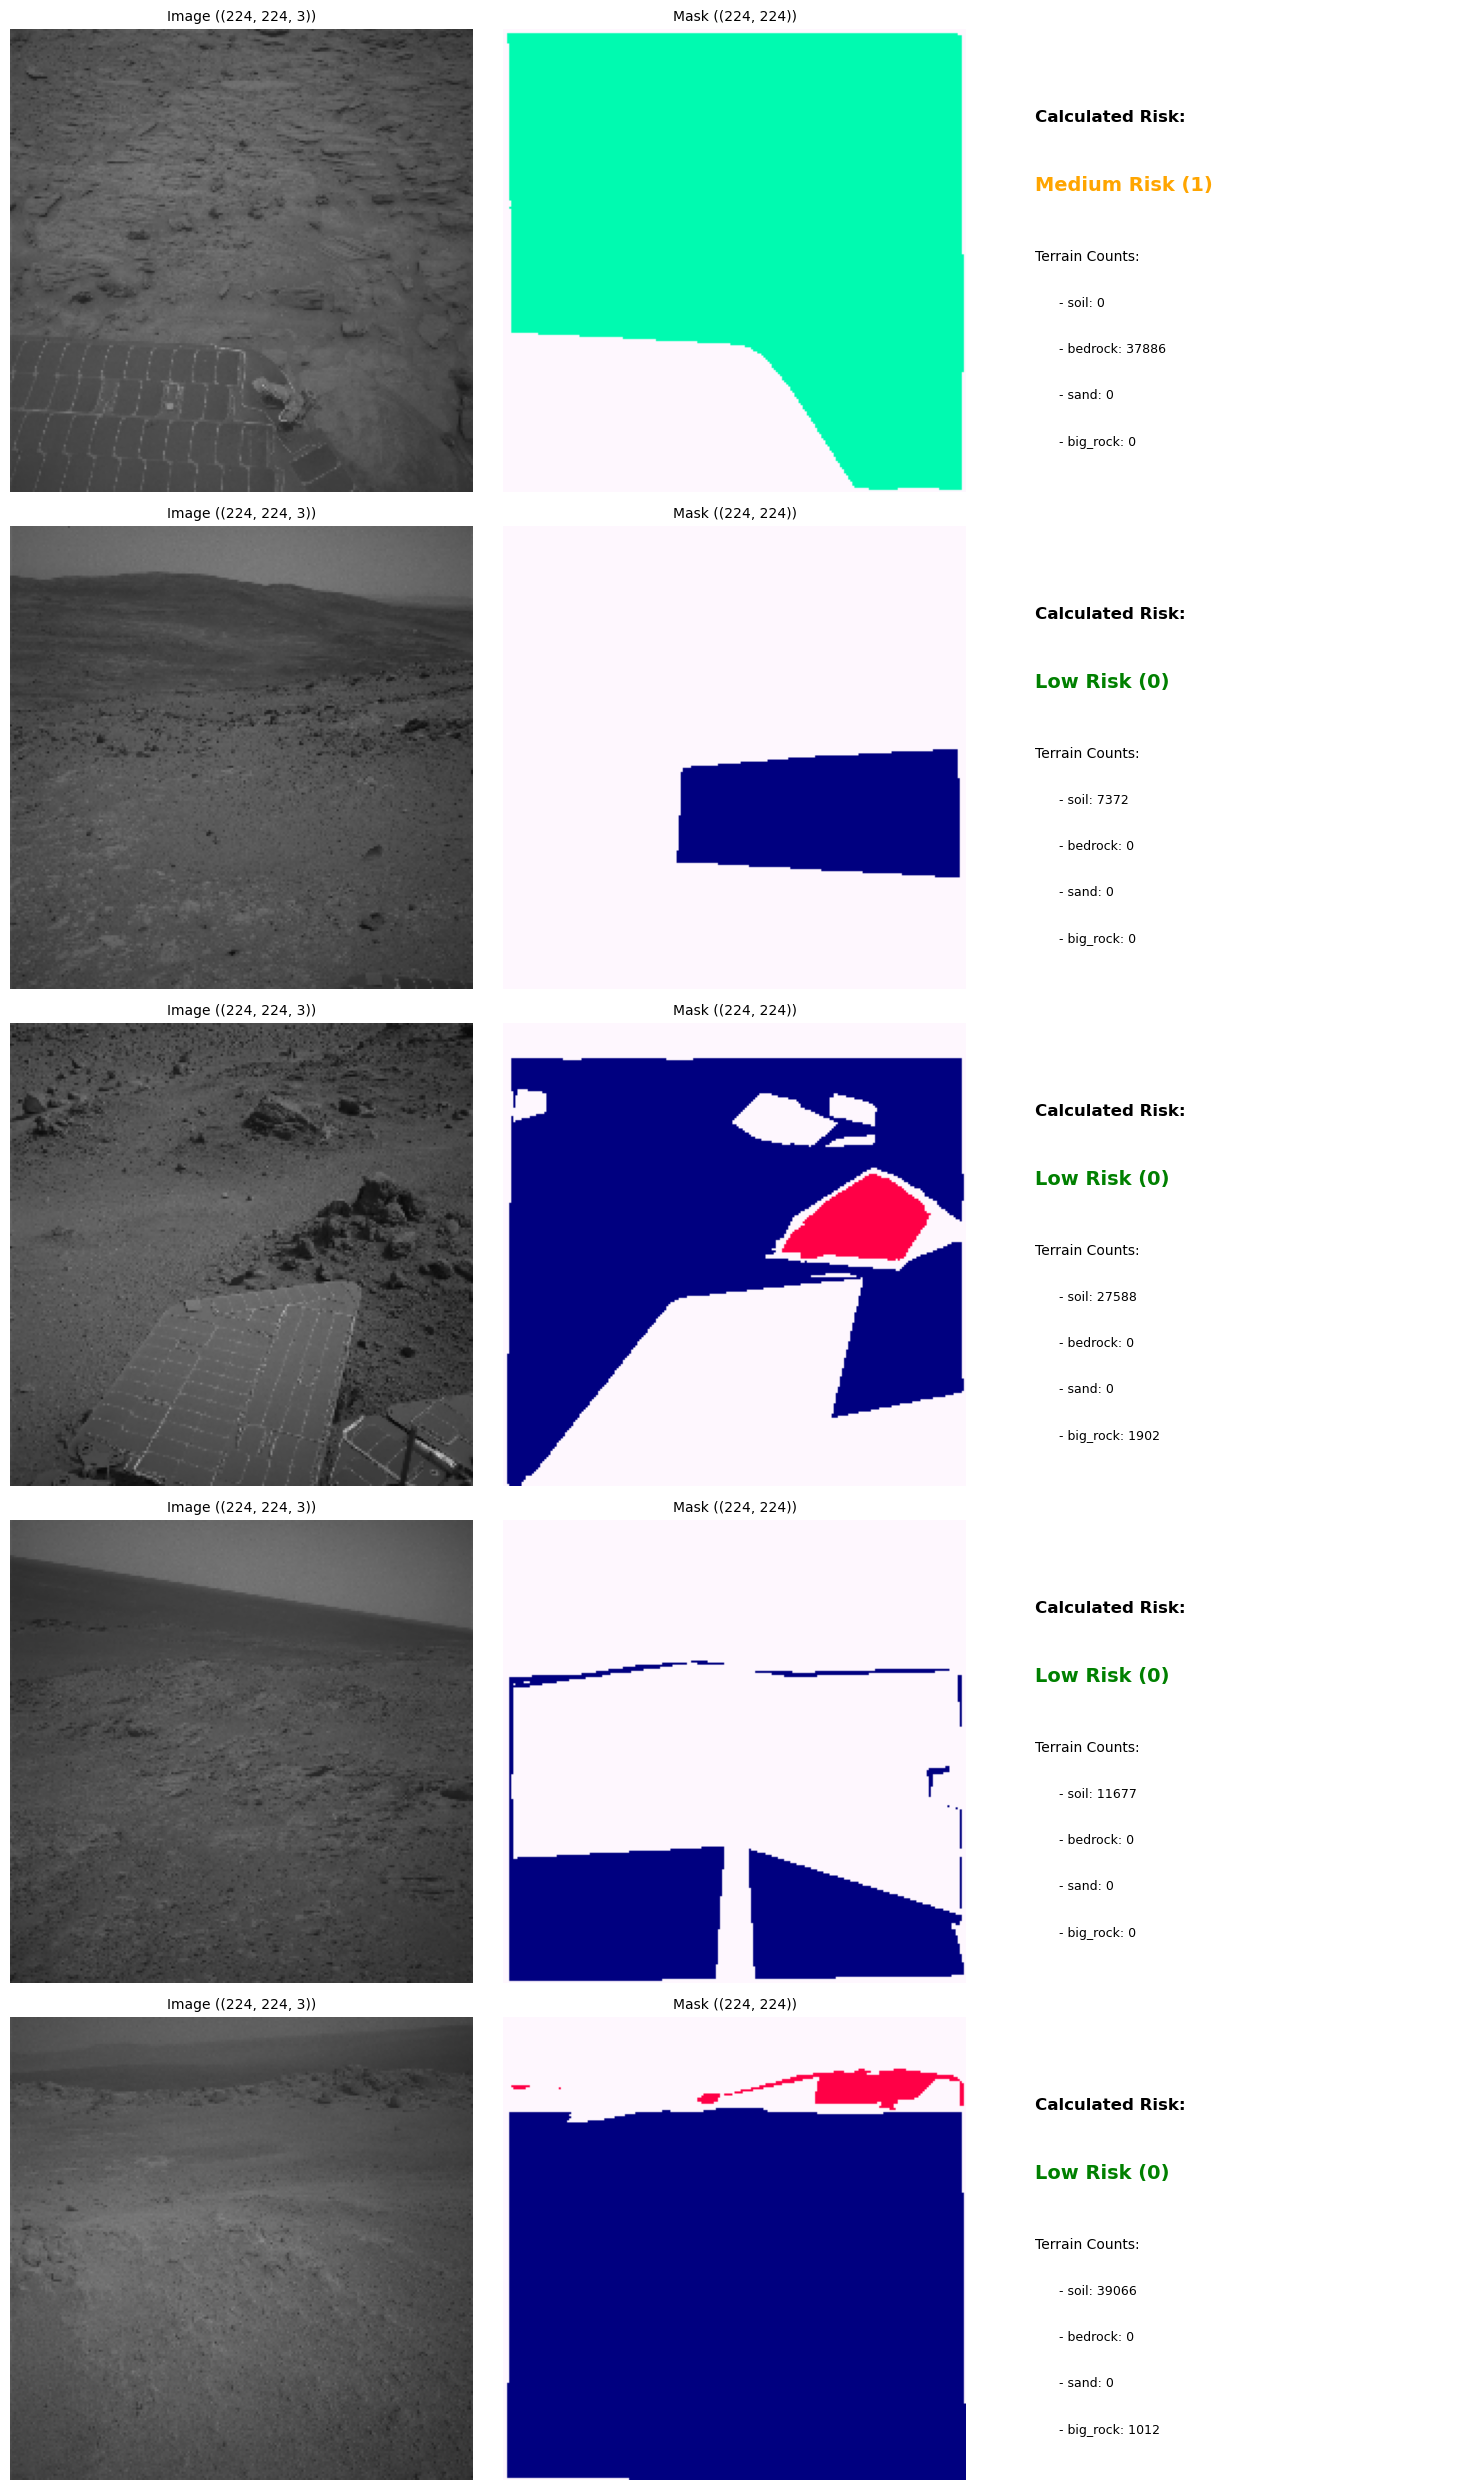

--- Verification Complete ---

--- Running Verification on test data ---

[Matching] Checking image directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/images/test
[Matching] Checking mask directory: /home/ws/180/notebooksWSL/final-project/ai4mars-dataset/data/mer/labels/test/masked-gold-min1-100agree
[Matching] Found 204 potential images.
[Matching] Found 204 mask candidates.
[Matching] Successfully identified 204 image/mask pairs.


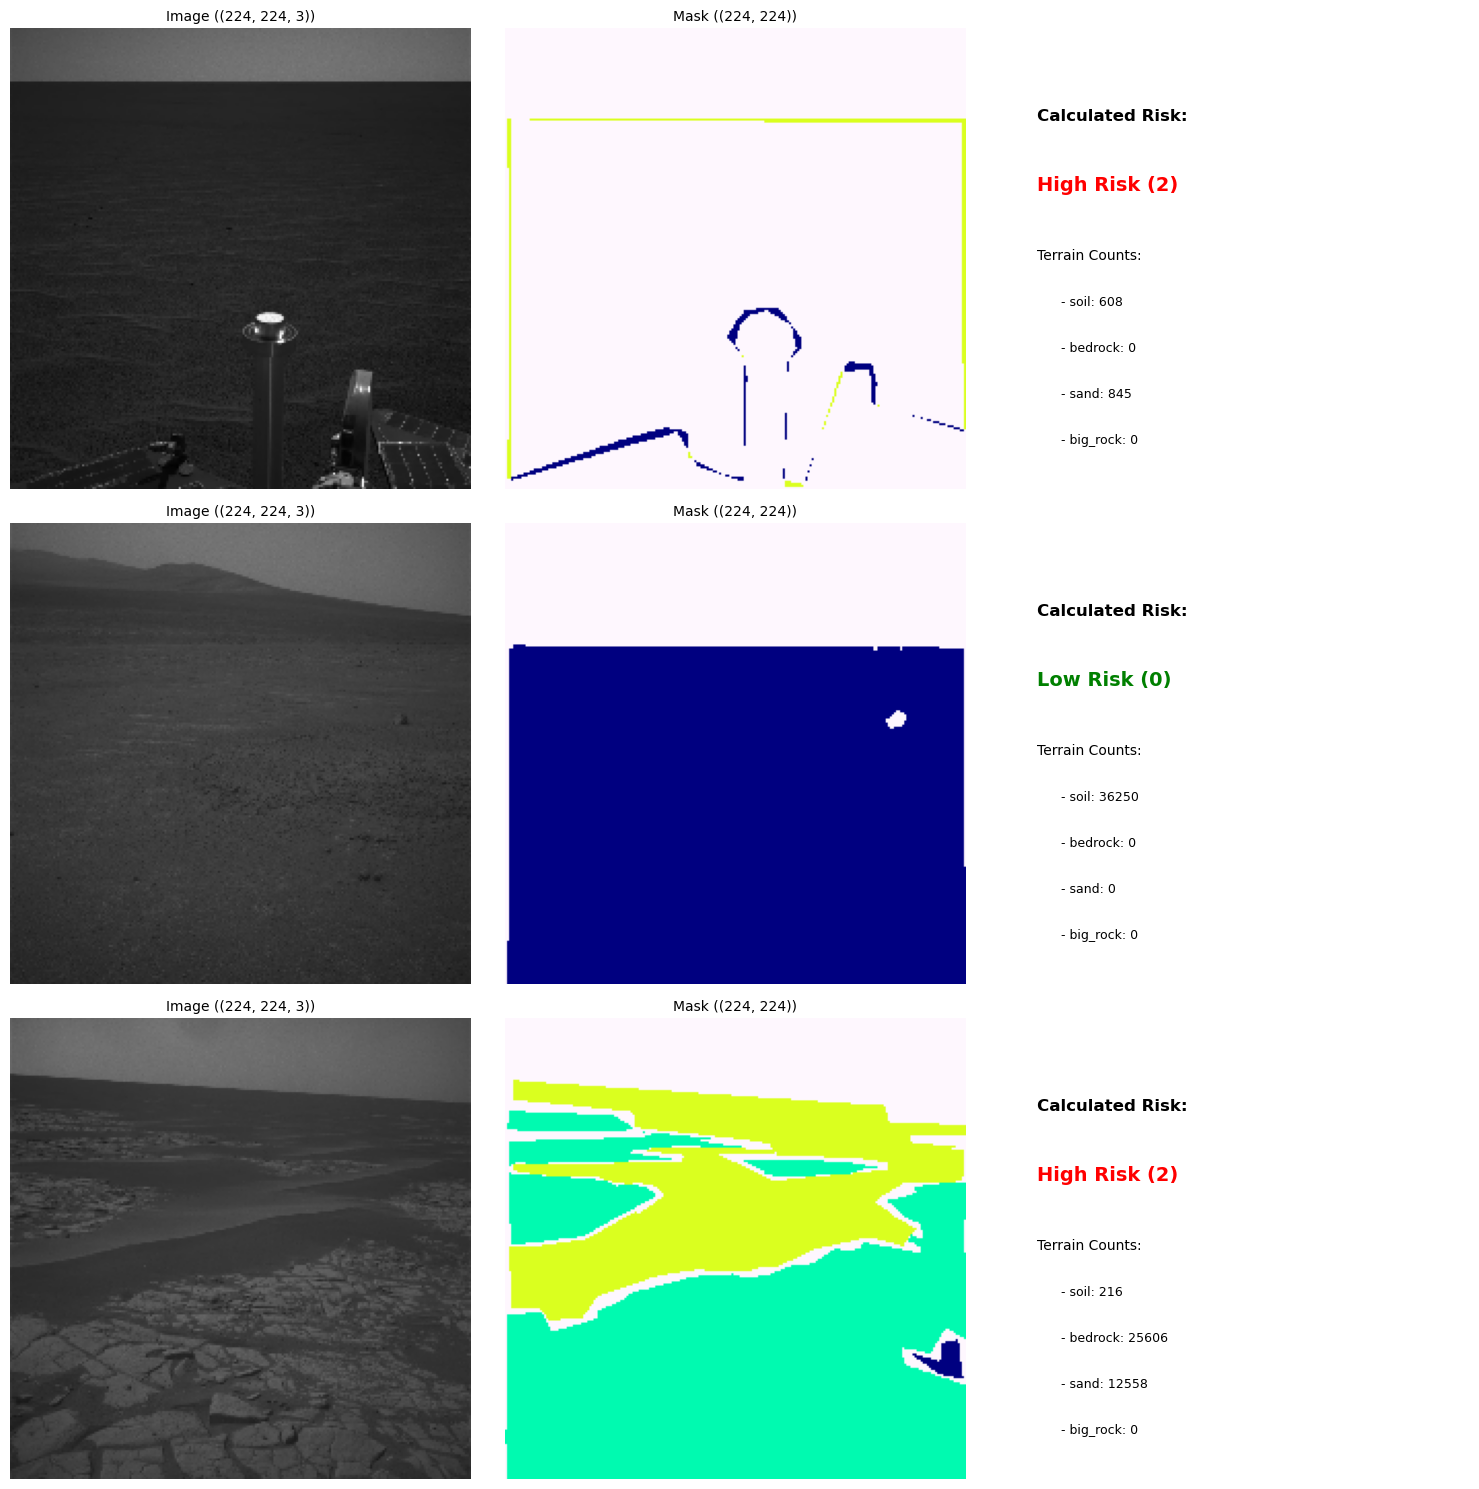

--- Verification Complete ---


In [7]:

# Verify 5 random samples from the Training Data
verify_dataset_sample(mer_train_img_dir, mer_train_mask_dir, num_samples=5)

# Verify 3 random samples from the Independent Test Data
verify_dataset_sample(mer_test_img_dir, mer_test_mask_dir, num_samples=3)

### Define Custom CNN model

In [11]:
from tensorflow.keras import layers, models, optimizers

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

model = models.Sequential([
        # --- Block 1: Feature Extraction ---
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # --- Block 2: Feature Extraction ---
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # --- Block 3: Feature Extraction ---
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # --- Classification Head ---
        # Reduces spatial dimensions to 1x1 while keeping depth
        layers.GlobalAveragePooling2D(), 
        
        # Classification layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        
        # Final output layer (using softmax for multi-class classification)
        layers.Dense(NUM_RISK_CLASSES, activation='softmax') 
    ])

### Compile CNN Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32

# Calculate steps per epoch
steps_per_epoch = int(np.ceil(total_train_samples / batch_size))
validation_steps = int(np.ceil(total_val_samples / batch_size))

model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy', # Appropriate for one-hot encoded labels
        metrics=['accuracy']
    )

model.summary()

callbacks = [
    # Stop training if validation accuracy doesn't improve for 5 epochs
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    # Save the best model weights
    ModelCheckpoint('basic-cnn.h5', monitor='val_accuracy', save_best_only=True)
]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      3

In [14]:
epochs = 50

history = model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

Epoch 1/50


234/234 [==============================] - 26s 106ms/step - loss: 0.5989 - accuracy: 0.7384 - val_loss: 0.7418 - val_accuracy: 0.6859
Epoch 2/50
234/234 [==============================] - 27s 110ms/step - loss: 0.5837 - accuracy: 0.7408 - val_loss: 0.7187 - val_accuracy: 0.6823
Epoch 3/50
234/234 [==============================] - 27s 110ms/step - loss: 0.5798 - accuracy: 0.7454 - val_loss: 0.7433 - val_accuracy: 0.6943
Epoch 4/50
234/234 [==============================] - 28s 112ms/step - loss: 0.5679 - accuracy: 0.7508 - val_loss: 0.7819 - val_accuracy: 0.6366
Epoch 5/50
234/234 [==============================] - 28s 114ms/step - loss: 0.5679 - accuracy: 0.7515 - val_loss: 1.0847 - val_accuracy: 0.6017
Epoch 6/50
234/234 [==============================] - 28s 115ms/step - loss: 0.5504 - accuracy: 0.7600 - val_loss: 0.7709 - val_accuracy: 0.6221
Epoch 7/50
234/234 [==============================] - 29s 116ms/step - loss: 0.5481 - accuracy: 0.7638 - val_loss: 0.6403 - val_accuracy: 0.7

/home/ws/.local/share/mamba/envs/tf-gpu2/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


234/234 [==============================] - 29s 116ms/step - loss: 0.5360 - accuracy: 0.7662 - val_loss: 0.7251 - val_accuracy: 0.6835
Epoch 9/50
234/234 [==============================] - 28s 114ms/step - loss: 0.5385 - accuracy: 0.7719 - val_loss: 0.7773 - val_accuracy: 0.7196
Epoch 10/50
234/234 [==============================] - 28s 115ms/step - loss: 0.5137 - accuracy: 0.7789 - val_loss: 0.6756 - val_accuracy: 0.7148
Epoch 11/50
234/234 [==============================] - 29s 118ms/step - loss: 0.5112 - accuracy: 0.7801 - val_loss: 0.6015 - val_accuracy: 0.7497
Epoch 12/50
234/234 [==============================] - 29s 116ms/step - loss: 0.5087 - accuracy: 0.7798 - val_loss: 0.9126 - val_accuracy: 0.6691
Epoch 13/50
234/234 [==============================] - 29s 115ms/step - loss: 0.4984 - accuracy: 0.7820 - val_loss: 0.8036 - val_accuracy: 0.6823
Epoch 14/50
234/234 [==============================] - 29s 116ms/step - loss: 0.4960 - accuracy: 0.7871 - val_loss: 0.7684 - val_accuracy

### Evaluate Model

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

class_names = ['low', 'medium', 'high'] 

test_steps = int(np.ceil(total_test_samples / batch_size))

model.load_weights('./basic-cnn.h5') 

raw_predictions = model.predict(test_ds, steps=test_steps)

y_true_list = []
    
 # Iterate over the dataset to get the labels
for _, labels in test_ds.take(test_steps):
# 'labels' are the one-hot encoded true labels for the current batch
    y_true_list.append(labels.numpy())
        
# Concatenate all batches of true labels into a single NumPy array
y_true_one_hot = np.concatenate(y_true_list, axis=0)

# 4. Convert one-hot encoded vectors to single class indices (0, 1, 2)
# Apply argmax to the predictions and the collected true labels
pred_indices = np.argmax(raw_predictions, axis=1)
y_true_indices = np.argmax(y_true_one_hot, axis=1)
    
# CRITICAL: Truncate predictions and true labels to match the exact number of samples
# The final batch might be incomplete, leading to extra data if we predicted 
# based on fixed 'test_steps' and not the exact number of samples.
y_true_indices = y_true_indices[:total_test_samples]
pred_indices = pred_indices[:total_test_samples]


# 5. Calculate and report metrics
score = accuracy_score(y_true_indices, pred_indices)
print("\n--- Results ---")
print(f"Final Test Accuracy: {score:.4f}")
    
# Classification report
report = classification_report(
    y_true_indices, 
    pred_indices, 
    target_names=class_names, 
    zero_division=0
)
print("\nClassification Report:")
print(report)

7/7 [==============================] - 2s 149ms/step

--- Results ---
Final Test Accuracy: 0.6618

Classification Report:
              precision    recall  f1-score   support

         low       0.65      0.69      0.67        80
      medium       0.54      0.72      0.61        53
        high       0.86      0.59      0.70        71

    accuracy                           0.66       204
   macro avg       0.68      0.67      0.66       204
weighted avg       0.69      0.66      0.67       204



[[55 22  3]
 [11 38  4]
 [18 11 42]]



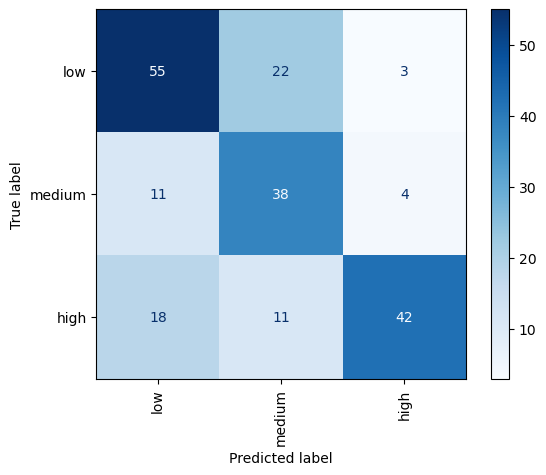

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_indices, pred_indices)
print(cm)
print()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='')
plt.show()